# Analiza wariantów

In [1]:
import os                               # moduł OS języka Python
user_name = os.environ.get('USER')      # pobieramy zmienną środowiskową USER
bucket = f"gs://edugen-lab-{user_name}2" # konstruujemy sciezke dostepowa do pliku
print(bucket)

gs://edugen-lab-tgambin2


In [4]:
# sprawdzenie czy dane są dostępne
! gsutil ls -r $bucket


gs://edugen-lab-tgambin2/bam/:
gs://edugen-lab-tgambin2/bam/mother.bam

gs://edugen-lab-tgambin2/fastq/:
gs://edugen-lab-tgambin2/fastq/
gs://edugen-lab-tgambin2/fastq/father.fastq
gs://edugen-lab-tgambin2/fastq/mother.fastq
gs://edugen-lab-tgambin2/fastq/son.fastq

gs://edugen-lab-tgambin2/ref/:
gs://edugen-lab-tgambin2/ref/ref.dict
gs://edugen-lab-tgambin2/ref/ref.fasta
gs://edugen-lab-tgambin2/ref/ref.fasta.amb
gs://edugen-lab-tgambin2/ref/ref.fasta.ann
gs://edugen-lab-tgambin2/ref/ref.fasta.bwt
gs://edugen-lab-tgambin2/ref/ref.fasta.fai
gs://edugen-lab-tgambin2/ref/ref.fasta.pac
gs://edugen-lab-tgambin2/ref/ref.fasta.sa

gs://edugen-lab-tgambin2/vcf/:
gs://edugen-lab-tgambin2/vcf/motherHC.vcf


## Przygotowanie sesji Spark


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.config('spark.driver.memory','1g') \
.config('spark.executor.memory', '2g') \
.getOrCreate()

## Stworzenie tabeli z wariantami

In [5]:
var_path=f"{bucket}/vcf/motherHC.vcf"
table_var = 'variants'

spark.sql(f'DROP TABLE IF EXISTS {table_var}')

spark.sql(f'CREATE TABLE IF NOT EXISTS {table_var} \
USING org.biodatageeks.sequila.datasources.VCF.VCFDataSource \
OPTIONS(path "{var_path}")')

DataFrame[]

## Weryfikacja danych

<div class="alert alert-block alert-warning">
<b>Zadanie 4_1:</b> 
Napisz polecenie, które pokaże strukturę (kolumny i ich typy) tabeli z wariantami
    </div>

In [6]:
spark.sql(f'select count (*) from {table_var}').show()

+--------+
|count(1)|
+--------+
|     410|
+--------+



Widzimy, że ALT jest rodzaju tablicowego, sprawdźmy, czy są warianty mutlialleliczne?

In [7]:
spark.sql(f'select * from {table_var} where size(alt) > 1').show()

+------+---------+--------+-----+------------+----------------+-------+-------+---------------------+-------+--------+-------------------+-------+--------------------+----------+-------+-------+-----------------+----------+----------+-------+-------+--------------+--------------+--------------------+
|contig|pos_start| pos_end|names|         ref|             alt|   qual|filters|splitFromMultiAllelic|INFO_AC|INFO_SOR|INFO_ReadPosRankSum|INFO_AN|INFO_InbreedingCoeff|   INFO_AF|INFO_FS|INFO_DP|INFO_BaseQRankSum|INFO_MLEAF|INFO_MLEAC|INFO_MQ|INFO_QD|INFO_MQRankSum|INFO_ExcessHet|           genotypes|
+------+---------+--------+-----+------------+----------------+-------+-------+---------------------+-------+--------+-------------------+-------+--------------------+----------+-------+-------+-----------------+----------+----------+-------+-------+--------------+--------------+--------------------+
|    20| 10008951|10008963|   []|CACACACACACA|[C, CCACACACACA]| 580.01|     []|               

In [8]:
spark.sql(f'select * from {table_var} where size(alt) > 1').count() # ile ich jest ? 

8

In [9]:
spark.sql(f'select genotypes from {table_var}').show(truncate=False) # tabela w postaci nieznormalizowanej -> mamy listę wartości

+-----------------------------------------------------------+
|genotypes                                                  |
+-----------------------------------------------------------+
|[[NA12878, 99, [11, 12], false, [0, 1], [291, 0, 292], 23]]|
|[[NA12878, 99, [21, 14], false, [0, 1], [355, 0, 526], 35]]|
|[[NA12878, 86, [0, 29], false, [1, 1], [795, 86, 0], 29]]  |
|[[NA12878, 90, [0, 30], false, [1, 1], [998, 90, 0], 30]]  |
|[[NA12878, 99, [17, 21], false, [0, 1], [571, 0, 398], 38]]|
|[[NA12878, 99, [0, 39], false, [1, 1], [1205, 117, 0], 39]]|
|[[NA12878, 99, [18, 15], false, [0, 1], [393, 0, 480], 33]]|
|[[NA12878, 89, [0, 30], false, [1, 1], [913, 89, 0], 30]]  |
|[[NA12878, 84, [0, 28], false, [1, 1], [1260, 84, 0], 28]] |
|[[NA12878, 81, [0, 27], false, [1, 1], [872, 81, 0], 27]]  |
|[[NA12878, 99, [19, 19], false, [0, 1], [522, 0, 480], 38]]|
|[[NA12878, 99, [0, 37], false, [1, 1], [1252, 111, 0], 37]]|
|[[NA12878, 99, [0, 43], false, [1, 1], [1808, 129, 0], 43]]|
|[[NA128

In [22]:
var_anno_path=f"gs://edugen-common-data2/anno/HG002_annotated.tsv"
table_var_anno= 'variants_anno'
spark.sql(f'DROP TABLE IF EXISTS {table_var_anno}')
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_var_anno} \
USING  CSV \
OPTIONS(HEADER true, INFERSCHEMA true, DELIMITER "\t" ) \
LOCATION  "{var_anno_path}"')

DataFrame[]

In [23]:
anno = spark.sql(f"select * from {table_var_anno}")

<div class="alert alert-block alert-warning">
<b>Zadanie 4_2:</b> 
Wyświetl schemat DF anno i podaj liczbę kolumn. Jakiego typu są nowe kolumny?
    </div>

<div class="alert alert-block alert-warning">
<b>Zadanie 4_3:</b> 
Pogrupuj warianty po kolumnie IMPACT oraz oblicz ile jest wariantów w każdej grupie. Zrób to samo dla kolumny Consequence oraz SYMBOL.
    </div>


## Biblioteka Pandas

https://pandas.pydata.org/

Moduł Pandas jest biblioteką Pythonową do manipulacji danymi. W szczegolnosci w pandas mozemy stworzyc ramki danych i wykonywac na niej analize, agregacje oraz wizualizacje danych. 
Przy nieduzych zbiorach danych i prostych operacjach to doskonała biblioteka. Jednak kiedy zbior danych sie rozrasta lub kiedy wymagane sa zlozone transformacje to operacje moga byc wolne.

Operacje na rozproszonych danych sa szybsze. Ale tu takze napotykamy ograniczenia np trudność w wizualizacji danych.

In [26]:
spark.sql(f"select * from {table_var_anno} LIMIT 10").toPandas()

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,...,Protein_change,posExon,posIntron,Position,UCSC_url,gnomADv3_url,dbSNP_url,ClinVar_url,OMIM_url,VarSome_url
0,chr1_15211_T_G,chr1:15211,G,653635,NR_024540.1,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,...,-,-,Intron 9/10,Intron 9/10,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-15...,https://www.ncbi.nlm.nih.gov/snp/rs3982632,-,-,https://varsome.com/variant/hg38/NR_024540.1:n...
1,chr1_16288_C_G,chr1:16288,G,653635,NR_024540.1,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,...,-,-,Intron 8/10,Intron 8/10,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-16...,https://www.ncbi.nlm.nih.gov/snp/rs113141985,-,-,https://varsome.com/variant/hg38/NR_024540.1:n...
2,chr1_16298_C_T,chr1:16298,T,653635,NR_024540.1,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,...,-,-,Intron 8/10,Intron 8/10,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-16...,https://www.ncbi.nlm.nih.gov/snp/rs2747966,-,-,https://varsome.com/variant/hg38/NR_024540.1:n...
3,chr1_17385_G_A,chr1:17385,A,653635,NR_024540.1,Transcript,"splice_polypyrimidine_tract_variant,intron_var...",-,-,-,...,-,-,Intron 5/10,Intron 5/10,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-17...,https://www.ncbi.nlm.nih.gov/snp/rs201535981,-,-,https://varsome.com/variant/hg38/NR_024540.1:n...
4,chr1_30923_G_T,chr1:30923,T,653635,NR_024540.1,Transcript,upstream_gene_variant,-,-,-,...,-,-,-,None,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-30...,https://www.ncbi.nlm.nih.gov/snp/rs806731,-,-,-
5,chr1_62777_A_T,chr1:62777,T,79501,NM_001005484.2,Transcript,upstream_gene_variant,-,-,-,...,-,-,-,None,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-62...,https://www.ncbi.nlm.nih.gov/snp/rs3844233,-,-,-
6,chr1_65797_T_C,chr1:65797,C,79501,NM_001005484.2,Transcript,intron_variant,-,-,-,...,-,-,Intron 2/2,Intron 2/2,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-65...,https://www.ncbi.nlm.nih.gov/snp/rs759525926,-,-,https://varsome.com/variant/hg38/NM_001005484....
7,chr1_65872_T_G,chr1:65872,G,79501,NM_001005484.2,Transcript,intron_variant,-,-,-,...,-,-,Intron 2/2,Intron 2/2,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-65...,https://www.ncbi.nlm.nih.gov/snp/rs796239852,-,-,https://varsome.com/variant/hg38/NM_001005484....
8,chr1_108310_T_C,chr1:108310,C,-,-,-,intergenic_variant,-,-,-,...,-,-,-,None,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-10...,https://www.ncbi.nlm.nih.gov/snp/rs74747225,-,-,-
9,chr1_108413_T_G,chr1:108413,G,-,-,-,intergenic_variant,-,-,-,...,-,-,-,None,http://genome-euro.ucsc.edu/cgi-bin/hgTracks?d...,https://gnomad.broadinstitute.org/variant/1-10...,https://www.ncbi.nlm.nih.gov/snp/rs4457511,-,-,-


**Ważne** Metoda toPandas() na ramce pyspark, konwertuje ramkę pyspark do ramki pandas. Wykonuje akcje pobrania wszystkich danych z executorów (z JVM) i transfer do  programu sterujacego (driver) i konwersje do typu Pythonowego w notatniku. Ze względu na ograniczenia pamięciowe w programie sterującym należy to wykonywać na podzbiorach danych.

Nie pokazują się wszystkie kolumny (w środku mamy ...). Aby wyświetlić całość musimy ustawić:

In [29]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [32]:
anno_pandas = anno.limit(10).toPandas()
anno_pandas

,Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IND,ZYG,REF_ALLELE,IMPACT,DISTANCE,STRAND,FLAGS,VARIANT_CLASS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,MANE_SELECT,MANE_PLUS_CLINICAL,ENSP,REFSEQ_MATCH,REFSEQ_OFFSET,GIVEN_REF,USED_REF,BAM_EDIT,SOURCE,SIFT,PolyPhen,EXON,INTRON,HGVSc,HGVSp,HGVS_OFFSET,CHECK_REF,ada_score,rf_score,1000Gp3_AF,1000Gp3_EUR_AF,ALSPAC_AF,Aloft_pred,Aloft_prob_Dominant,Aloft_prob_Recessive,Aloft_prob_Tolerant,CADD_phred,DANN_score,DEOGEN2_pred,Eigen-PC-raw_coding_rankscore,Eigen-raw_coding_rankscore,FATHMM_converted_rankscore,FATHMM_pred,GERP++_RS_rankscore,Interpro_domain,LRT_converted_rankscore,LRT_pred,M-CAP_pred,M-CAP_rankscore,MPC_rankscore,MVP_rankscore,MetaLR_pred,MetaLR_rankscore,MetaSVM_pred,MetaSVM_rankscore,MutPred_Top5features,MutPred_protID,MutPred_rankscore,MutPred_score,MutationAssessor_pred,MutationAssessor_rankscore,MutationTaster_pred,MutationTaster_score,PROVEAN_converted_rankscore,PROVEAN_pred,Polyphen2_HDIV_pred,Polyphen2_HDIV_rankscore,Polyphen2_HVAR_pred,Polyphen2_HVAR_rankscore,PrimateAI_pred,PrimateAI_rankscore,REVEL_rankscore,SIFT4G_converted_rankscore,SIFT4G_pred,SIFT_converted_rankscore,SIFT_pred,SiPhy_29way_logOdds,SiPhy_29way_logOdds_rankscore,VEST4_rankscore,clinvar_MedGen_id,clinvar_Orphanet_id,clinvar_clnsig,clinvar_id,clinvar_trait,fathmm-MKL_coding_pred,fathmm-MKL_coding_rankscore,fathmm-XF_coding_pred,fathmm-XF_coding_rankscore,gnomAD_exomes_AC,gnomAD_exomes_AF,gnomAD_exomes_AFR_AF,gnomAD_exomes_AMR_AF,gnomAD_exomes_ASJ_AF,gnomAD_exomes_EAS_AF,gnomAD_exomes_FIN_AF,gnomAD_exomes_NFE_AF,gnomAD_exomes_POPMAX_AF,gnomAD_exomes_POPMAX_nhomalt,gnomAD_exomes_SAS_AF,gnomAD_exomes_controls_AF,gnomAD_exomes_controls_NFE_AC,gnomAD_exomes_controls_NFE_AF,gnomAD_exomes_controls_NFE_AN,gnomAD_exomes_controls_NFE_nhomalt,gnomAD_exomes_controls_POPMAX_AF,gnomAD_exomes_controls_POPMAX_nhomalt,gnomAD_exomes_nhomalt,hg19_pos(1-based),integrated_fitCons_rankscore,phastCons100way_vertebrate_rankscore,phastCons17way_primate_rankscore,phastCons30way_mammalian_rankscore,phyloP100way_vertebrate_rankscore,phyloP17way_primate_rankscore,phyloP30way_mammalian_rankscore,PHENOTYPES,clinvar.vcf.gz,clinvar.vcf.gz_CLNSIG,clinvar.vcf.gz_CLNDN,clinvar.vcf.gz_CLNREVSTAT,OMIMinheritance,OMIMgeneMIM,OMIMphenotype,OMIMcytoband,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_nfe,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_fin,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_afr,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_amr,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_asj,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_eas,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_sas,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_ami,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_AF_oth,gnomad.genomes.v3.1.2.no.chrM.trimmed.vcf.gz_nhomalt,CosmicCodingMuts.normal.vcf.gz,CosmicCodingMuts.normal.vcf.gz_LEGACY_ID,CosmicCodingMuts.normal.vcf.gz_CDS,CosmicCodingMuts.normal.vcf.gz_AA,CosmicCodingMuts.normal.vcf.gz_CNT,HPO.bed.gz,CHROM,POS,REF,ALT,QUAL,FILTER,INFO,FORMAT,genotype,AD,DP,GT,sample_source,Allelic_balance,DNA_change,Protein_change,posExon,posIntron,Position,UCSC_url,gnomADv3_url,dbSNP_url,ClinVar_url,OMIM_url,VarSome_url
0,chr1_15211_T_G,chr1:15211,G,653635,NR_024540.1,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,-,-,-,HG002,HOM,T,MODIFIER,-,-1,-,SNV,WASH7P,EntrezGene,-,transcribed_pseudogene,-,-,-,-,-,T,T,OK,-,-,-,-,9/10,NR_024540.1:n.1233-173A>C,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,rs3982632,0.117986,0.185669,0.0621512,0.0514635,0.103197,0.287572,0.0344615,0.133653,0.178771,0.145089,37,-,-,-,-,-,-,chr1,15211,T,G,48.32,LowDP;LowMQ,A

# Matplotlib
https://pandas.pydata.org/pandas-docs/version/0.23.4/api.html#api-dataframe-plotting

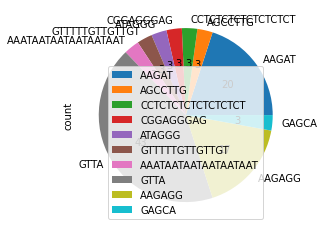

In [49]:
anno2 = anno.groupby("ref").count().limit(10).toPandas()
anno2.plot.pie(y='count', labels=anno2['ref'],  autopct='%.0f')
plt.legend(loc="lower center")
plt.show()

<div class="alert alert-block alert-warning">
<b>Zadanie 4_4:</b> 
Przerób powyższe dwa rysunki, tak żeby pokazywały rozkład referencji tylko dla SNV (bez indeli).
    </div>



<div class="alert alert-block alert-warning">
<b>Zadanie 4_5:</b> 
Przygotuj pie chart dla kolumny Consequences. Uwzględnij jedną konsekwencję dla każdego wariantu.
    </div>



In [ ]:
spark.stop()